Solution for [The Simpsons Classification](https://www.kaggle.com/competitions/journey-springfield/overview) Kaggle competition

In [ ]:
import os
import random
import math
from pathlib import Path
import PIL

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import f1_score

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

**Load the dataset:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/dls_hw/journey-springfield.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/simpsons_dataset/moe_szyslak/pic_1025.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1036.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1037.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1038.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1039.jpg  
  in

In [ ]:
train_dir = "/content/train/simpsons_dataset"
test_dir = "/content/testset"

**Augment train dataset:**

In [ ]:
data_files = sorted(list(Path(train_dir).rglob('*.jpg')))
data_labels = [path.parent.name for path in data_files]

In [ ]:
df = pd.DataFrame(data_labels, columns=["class"])
df["count"] = 1
df = df.groupby("class").count().sort_values("count", ascending=False)

# amount of images we shoud add to get at least 1000 instances of each class
df["to_add"] = df["count"].apply(lambda x: 1000 - x if x < 1000 else 0)

# how many images we should make from original one
df["one_iteration"] = df.apply(lambda x: math.ceil(x["to_add"] / x["count"]), axis=1)
df

,count,to_add,one_iteration
class,,,
homer_simpson,2246,0,0
ned_flanders,1454,0,0
moe_szyslak,1452,0,0
lisa_simpson,1354,0,0
bart_simpson,1342,0,0
marge_simpson,1291,0,0
krusty_the_clown,1206,0,0
principal_skinner,1194,0,0
charles_montgomery_burns,1193,0,0


In [ ]:
def load_image(file):
    image = PIL.Image.open(file)
    image.load()
    return image

In [ ]:
augmenter = torchvision.transforms.Compose([
                                torchvision.transforms.Resize(size=300, max_size=301),
                                torchvision.transforms.CenterCrop(size=300),
                                torchvision.transforms.RandomCrop(250),
                                torchvision.transforms.RandomHorizontalFlip()
                                ])

In [ ]:
for image_path in data_files:
    path = image_path.parents[0]
    label = image_path.parent.name
    img = load_image(image_path)

    if df.loc[label]["to_add"] == 0:
        continue

    if df.loc[label]["one_iteration"] > df.loc[label]["to_add"]:
        iter_size = df.loc[label]["to_add"]
    else:
        iter_size = df.loc[label]["one_iteration"]
    df.loc[label]["to_add"] -= iter_size
    
    for i in range(iter_size):
        aug_img = augmenter(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")

In [ ]:
aug_files = sorted(list(Path(train_dir).rglob('*.jpg')))
aug_labels = [path.parent.name for path in aug_files]
df = pd.DataFrame(aug_labels, columns=["class"])
df["count"] = 1
df = df.groupby("class").count().sort_values("count", ascending=False)
df

,count
class,
homer_simpson,2246
ned_flanders,1454
moe_szyslak,1452
lisa_simpson,1354
bart_simpson,1342
marge_simpson,1291
krusty_the_clown,1206
principal_skinner,1194
charles_montgomery_burns,1193


**Prepare resnet50 model:**

In [ ]:
weights = ResNet50_Weights.IMAGENET1K_V2
preprocess = weights.transforms()

model = resnet50(weights=weights)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Freeze layers and create new fully_connected layer:**

In [ ]:
for param_name, param in model.named_parameters():
  if not param_name.startswith("layer4"):
    param.requires_grad = False

num_classes = len(df.index.to_list()) # 42
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=num_classes, bias=True)

**Prepare train and val datasets:**

In [ ]:
full_data = torchvision.datasets.ImageFolder(root=os.path.join(train_dir), transform=preprocess)
n_train = int(np.floor(0.8 * len(full_data)))
n_val = len(full_data) - n_train
print(n_train, n_val)

train_dataset, val_dataset = torch.utils.data.random_split(full_data, [n_train, n_val])

36648 9163


**Create DataLoaders:**

In [ ]:
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

**Optimizer:**

In [ ]:
model = model.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

**Criterion:**

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

**Training and Validation:**

In [ ]:
def train_epoch(model, optimizer, criterion, dataloader, device):
  model.train()
  running_loss = 0
  acc = 0

  for input, target in dataloader:
    input = input.to(device)
    target = target.to(device)
    output = model(input)

    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    running_loss += loss.item()
    acc += torch.sum(torch.argmax(output, 1) == target).item()
  
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_acc = acc / len(dataloader.dataset)
  
  return epoch_loss, epoch_acc

def eval_epoch(model, optimizer, criterion, dataloader, device):
  model.eval()
  running_loss = 0
  acc = 0

  with torch.no_grad():
    for input, target in dataloader:
      input = input.to(device)
      target = target.to(device)
      output = model(input)

      loss = criterion(output, target)
      running_loss += loss.item()

      acc += torch.sum(torch.argmax(output, 1) == target).item()
  
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_acc = acc / len(dataloader.dataset)
  
  return epoch_loss, epoch_acc

In [ ]:
num_epochs = 5

losses = {"train": [], "val": []}
accuracies = {"train": [], "val": []}

for epoch in range(num_epochs):
  train_loss, train_acc = train_epoch(model, optimizer, criterion, train_dataloader, device)
  losses["train"].append(train_loss)
  accuracies["train"].append(train_acc)

  val_loss, val_acc = eval_epoch(model, optimizer, criterion, val_dataloader, device)
  losses["val"].append(val_loss)
  accuracies["val"].append(val_acc)

  print(f"Epoch #{epoch}:")
  print(f"Training Loss: {train_loss} Acc: {train_acc}")
  print(f"Evaluation Loss: {val_loss} Acc: {val_acc}")
  print()

Epoch #0:
Training Loss: 0.004645817781051867 Acc: 0.9256439641999563
Evaluation Loss: 0.0016214452904178387 Acc: 0.9719524173305686

Epoch #1:
Training Loss: 0.000805818937200247 Acc: 0.986847849814451
Evaluation Loss: 0.0012119053910632457 Acc: 0.9805740478009386

Epoch #2:
Training Loss: 0.0004452970272815894 Acc: 0.9927690460598123
Evaluation Loss: 0.0007521228947028055 Acc: 0.9875586598275674

Epoch #3:
Training Loss: 0.0002700346880108287 Acc: 0.9950611220257586
Evaluation Loss: 0.0010908488894721261 Acc: 0.9833024118738405

Epoch #4:
Training Loss: 0.0003122227015706533 Acc: 0.9942970967037764
Evaluation Loss: 0.0010996034446152 Acc: 0.9837389501255047



In [ ]:
def plot_metrics(losses, accuracies):
    def show_ax(ax_idx, metric, title):
        axes[ax_idx].plot(metric["train"], label="train")
        axes[ax_idx].plot(metric["val"], label="val")
        axes[ax_idx].grid()
        axes[ax_idx].legend()
        axes[ax_idx].set_title(title)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    show_ax(0, losses, "loss")
    show_ax(1, accuracies, "accuracy")
    plt.show()

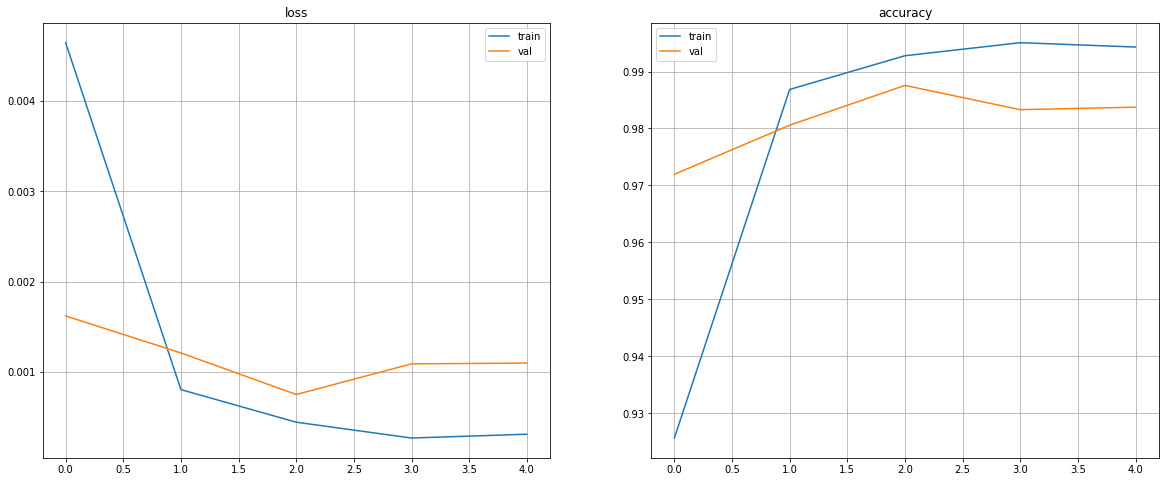

In [ ]:
plot_metrics(losses, accuracies)

**Compute f1-score on val dataset:**

In [ ]:
def predict(model, test_loader):
    logits = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = torch.nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
probs = predict(model, val_dataloader)
y_pred = np.argmax(probs, -1)
print(y_pred.shape)
y_true = np.array([val_dataset.dataset[i][1] for i in val_dataset.indices])
print(y_true.shape)

print(f1_score(y_true, y_pred, average="micro"))
print(f1_score(y_true, y_pred, average="macro"))

(9163,)
(9163,)
0.9837389501255047
0.985297571847516


**Predict:**

In [ ]:
def predict_to_submission(model, test_loader, dataset_classes, test_filenames):
    probs = predict(model, test_loader)
    predictions = np.argmax(probs, -1)
    preds = list(dataset_classes[predictions])
    submission = pd.read_csv("/content/sample_submission.csv")
    submission = pd.DataFrame({"Id": test_filenames, "Expected": preds})
    submission.to_csv("submission.csv", index=False)

In [ ]:
test_dataset = torchvision.datasets.ImageFolder(root=os.path.join(test_dir), transform=preprocess)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
test_filenames = [fn[0].split('/')[-1] for fn in test_dataset.imgs]
predict_to_submission(model, test_loader, np.array(full_data.classes), test_filenames)